In [1]:
#Pacotes que precisam ser instalados

from __future__ import print_function
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import skimage.io
import matplotlib.pyplot as plt

import osr
from osgeo import gdal, ogr

from rasterstats import zonal_stats

import sys

import json
import geopandas as gpd
from shapely.geometry import shape

import warnings #Pacote para remover as mensagens de alerta.
warnings.filterwarnings('ignore')

In [2]:
# Importar imagem e obter os parametros de projeções

#Importar a imagem. Adicionar o caminho de onde está salvo o arquivo (imagem exportada do Google Engine).
imagepath = 'D:\\teste\\mosaico.tif'  

#Leitura do metadado da imagem. Se o ds for None, significa que não conseguiu abrir.
ds = gdal.Open(imagepath)  
    
if ds is None:
  print ('Could not open image file')
  sys.exit(1)
    
#Lendo a imagem. Imagem foi nomeada como "img". 
img = skimage.io.imread(imagepath, as_gray=False, plugin="gdal")

In [3]:
#Verificar como o Google Engine salvou a imagem.  Quando for aplicar o SLIC a imagem precisa ser transposta.
#O resultado aparece na seguinte ordem: número de bandas, número de pixels em y e número de pixels em x)
img.shape

(18465, 17720, 3)

In [4]:
#Transponda a imagem para aplicar o SLIC.
#O resulatdo aparece a seguinte ordem: número de pixels em y, número de pixels em x e o número de bandas.
#img = img.transpose(1, 2, 0)
#img.shape

In [10]:
#Segmentação da imagem com o SLIC.

#seg=slic(img, n_segments=15000, compactness=700, convert2lab=False,multichannel=True)
seg=slic(img, n_segments=400000, compactness=1000, convert2lab=False,multichannel=True)

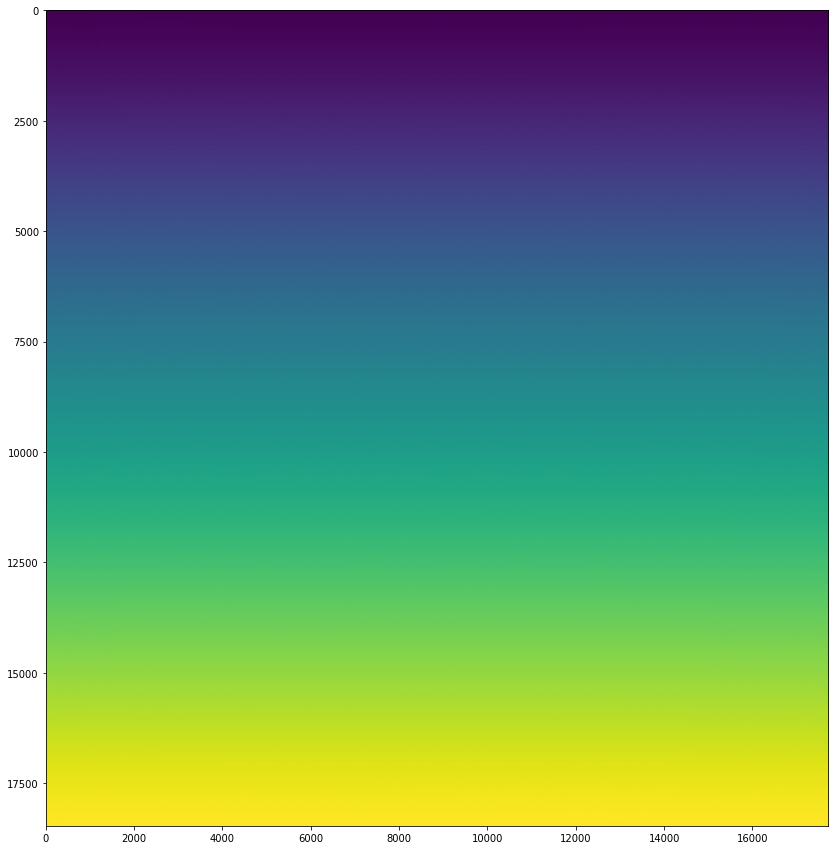

In [11]:
#Plotar a imagem com os segementos gerados pelo SLIC.
plt.figure(figsize=(15,15)) #figsize = tamanho da imagem que aparece na tela.
plt.imshow(seg); #plotar a imagem.

In [12]:
#Verificar o tamanho da imagem e adicionar o x_pixels e y_pixels no tif de saida.

print("x: {}".format(img.shape[1]))
print("y: {}".format(img.shape[0]))

x: 17720
y: 18465


In [13]:
#Exportar os segmentos como RASTER e com a projecao da imagem de entrada.

dst_filename = r'D:\\teste\\slic_comp0000.tif' #Definindo o nome e o local de saída do Raster segmentado pelo SLIC.
x_pixels = img.shape[1]  #número de x_pixels do comando de cima.
y_pixels = img.shape[0]  #número de y_pixels do comando de cima.
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(seg)

#Adição da projeção no RASTER segmentado.
geotrans=ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=ds.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

In [14]:
#Poligonizando o RASTER

#Criando o sistema de projeção
sr = osr.SpatialReference()   # create spatial reference object
sr.ImportFromEPSG(4326)       # set it to EPSG:4326

#Abrindo o Raster do SLIC
raster = gdal.Open(dst_filename)
#Pegando a banda 1 do Raster do SLIC.
band = raster.GetRasterBand(1)

#Salvando o shp do SLIC.
outshp_name = r'D:\\teste\\'
drv = ogr.GetDriverByName("ESRI Shapefile")
outfile = drv.CreateDataSource(outshp_name) 
outlayer = outfile.CreateLayer('slic_comp1000', srs = sr )
newField = ogr.FieldDefn('DN', ogr.OFTReal)
outlayer.CreateField(newField)

#Convertendo a banda 1 do SLIC para o Shp de saída.
gdal.Polygonize(band, None, outlayer, 0, [])
outfile = None

In [10]:
#Extrair as estatísticas de cada banda.

#Criando um GeoDataFrame vazio.
gdf_total = None

#Para cada banda da imagem extraída do Google Engine
for band in range(1,img.shape[2]+1):   
    #Extraindo as estatísticas zonais.
    stats = zonal_stats(outshp_name, 
                    imagepath, 
                    stats=['mean'], #Extraíndo a média da banda selecionada.
                    all_touched=True, 
                    geojson_out=True,
                    band_num=band)
    mean_label = "mean_{}".format(band) #Criando o nome de cada coluna.
    #Para cada segmento 
    for d in stats:
        #Cria um objeto geométrico
        d['the_geom'] = shape(d['geometry'])
        # Extrai a estatítisca
        d[mean_label] = d['properties']['mean']   
        # Remove as colunas desnecessárias
        del d['properties']
        del d['type']
        del d['geometry']
        
    # Criando GeoDataFrame da banda    
    gdf = gpd.GeoDataFrame(stats, crs={'init' :'epsg:4326'}).set_geometry('the_geom')
    
    # Se o GDF total já existir 
    if gdf_total is not None: 
        # Adiciona a estatística nele
        gdf_total[mean_label] = gdf[mean_label]
    else: #se não
        # Copia o GDF inteiro
        gdf_total = gdf

In [11]:
# Mostrar as primeiras linhas GFD. Apenas para conferência.
gdf_total.head()

,id,the_geom,mean_1,mean_2,mean_3
0,0,"POLYGON ((-55.03520 -16.50942, -54.74621 -16.5...",600.315228,621.107905,2444.970417
1,1,"POLYGON ((-54.95543 -16.52101, -54.95498 -16.5...",557.092721,478.269613,2416.014858
2,2,"POLYGON ((-54.74621 -16.50942, -54.62637 -16.5...",829.199382,956.498869,2953.569185
3,3,"POLYGON ((-54.82508 -16.53978, -54.82499 -16.5...",498.690719,424.639678,2271.376874
4,4,"POLYGON ((-54.62637 -16.50942, -54.53385 -16.5...",648.586532,633.254814,2787.549780


In [12]:
# Salvando o Shp dos segmentos SLIC com a média de cada banda nas colunas.
shape_saida_stats = r'D:\\teste\\slic_stats_400mil.shp'
gdf_total.to_file(shape_saida_stats)